# Pattern Project : signature identification

## A: Preprocessing

### import library

In [10]:
import os
import cv2
import numpy as np
from sklearn import svm
import matplotlib.pyplot as pt
from skimage.feature import hog
from skimage import data, exposure
from skimage.morphology import thin
from sklearn.decomposition import PCA
from skimage.morphology import opening
from skimage.measure import regionprops
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [11]:
# read dataset from directory and split train test data
def readDataSet1(path):
    labels_str_list = os.walk(path).__next__()[1]
    Labels = list()
    Dataset = list()
    for el in labels_str_list:
        sign_path = os.path.join(path,el)
        member_sign = os.walk(sign_path).__next__()[2]
        for ms in member_sign:
            Dataset.append(pt.imread(os.path.join(sign_path,ms))) 
            Labels.append(int(el))        
    return Dataset,Labels
def readDataSet2(path,signer_count,sign_count):
    sign_list = list()
    label = list()
    for n in range(1,signer_count+1):
        for m in range(1,sign_count+1):
            sign_list.append(pt.imread(os.path.join(path,'original_'+str(n)+"_"+str(m)+".png")))
            label.append(n)
    
    return sign_list,label

In [12]:
# transform image to binary image use treshold
#ref:https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_thresholding/py_thresholding.html
def image_segmentation(img):
    ret2,th2 = cv2.threshold(img,0,1,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    th2 = np.array(th2).astype(np.uint)
    return th2

In [13]:
# resize image 
def image_resize(img,h,l):
    resized_image = cv2.resize(img,(h,l))
    return resized_image

In [14]:
def morpho_operation(image):
    kernel = np.ones((2,2),np.uint8)
    opening_skimage = opening(image, kernel)
    return opening_skimage

In [15]:
# Class dataset
X1,L1=readDataSet1('F:\MSCCourse\991\PatternRecognition\project\DataSet1')
# CEDAR dataset
X2,L2=readDataSet2('F:\MSCCourse\991\PatternRecognition\project\DataSet2',20,5)

## B: Preprocessing 

In [16]:
def preprocessing(dataset):
    n = len(dataset)
    resized_dataset = []
    binary_dataset = []
    morpho_dataset = []
    N_dataset = []
    for i in range(n):
        if len(np.shape(dataset[0]))==3:
            gray_dataset = cv2.cvtColor(dataset[i], cv2.COLOR_BGR2GRAY)
        else:
            gray_dataset = np.array(dataset[i]*255).astype(np.uint8)
        resized_dataset.append(image_resize(gray_dataset,200,200))
        binary_dataset.append(image_segmentation(resized_dataset[i]))
        morpho_dataset.append(morpho_operation(binary_dataset[i]))
        N_dataset.append(1-morpho_dataset[i])
    return resized_dataset,binary_dataset,morpho_dataset, N_dataset

In [17]:
resized_dataset1,binary_dataset1,morpho_dataset1, N_dataset1=preprocessing(X1)
resized_dataset2,binary_dataset2,morpho_dataset2, N_dataset2=preprocessing(X2)

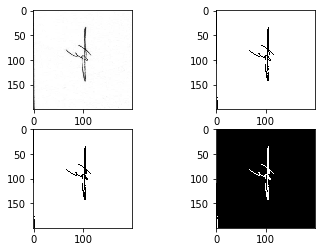

In [18]:
fig = pt.figure()
pt.subplot(2, 2, 1)
pt.imshow(resized_dataset1[49],cmap='gray')
pt.subplot(2, 2, 2)
pt.imshow(binary_dataset1[49],cmap='gray')
pt.subplot(2, 2, 3)
pt.imshow(morpho_dataset1[49],cmap='gray')
pt.subplot(2, 2, 4)
pt.imshow(N_dataset1[49],cmap='gray')
pt.show()

## C: Feature Extraction

#### Global Feature

In [19]:
def Area(Image):
    H,W =np.shape(Image)
    activepixelnumber= np.sum(Image)
    totalpixel = H*W
    return activepixelnumber/totalpixel

In [20]:
def Width(Image):
    H,W=np.shape(Image)
    verticalpixeltotal=np.sum(Image,0)
    for i in range(W):
        if (verticalpixeltotal[i]>=3):
            lower = i
            break
    for j in range(W-1,-1,-1):
        if (verticalpixeltotal[j]>=3):
            upper = j
            break   
    return upper -lower

In [21]:
def Height(Image):
    H,W=np.shape(Image)
    horizontalpixeltotal=np.sum(Image,1)
    for i in range(H):
        if (horizontalpixeltotal[i]>=3):
            lower = i
            break
    for j in range(H-1,-1,-1):
        if (horizontalpixeltotal[j]>=3):
            upper = j
            break
    return upper -lower

In [22]:
def PureWidth(Image):
    H,W=np.shape(Image)
    verticalpixeltotal=np.sum(Image,0)
    return max(verticalpixeltotal)

In [23]:
def PureHeight(Image):
    H,W=np.shape(Image)
    horizontalpixeltotal=np.sum(Image,1)
    return max(horizontalpixeltotal)

#### Local Feature

In [24]:
def CalculateCentroid(Image,hl,hu,wl,wu):
    mysum=0
    for i in range(hl,hu):
        mysum += i*sum(Image[i,wl:wu])
    htotal = mysum 
    mysum=0 
    for i in range(wl,wu):
        mysum += i*sum(Image[hl:hu,i])
    vtotal = mysum
    totalactivepixel = np.sum(Image[hl:hu,wl:wu])
    try:
        CY=int(np.ceil(htotal/totalactivepixel))
        CX=int(np.ceil(vtotal/totalactivepixel))
        return CX,CY
    except:
        CY=1
        CX=1
        return CX,CY

In [25]:
def ExtractHVFeature(Image,hl,hu,wl,wu,n,HVstatus,l,plimage):
    if n ==1 :  
        CX,CY = CalculateCentroid(Image,hl,hu,wl,wu)
        l.append(CX)
        l.append(CY)
        if HVstatus == True:
            plimage[CY,wl:wu]=1
           
        if HVstatus ==False:
            plimage[hl:hu,CX]=1
        
           
        
    else:
        CX,CY = CalculateCentroid(Image,hl,hu,wl,wu)
        l.append(CX)
        l.append(CY)
        
        if HVstatus == True:
            HVstatus = False
            plimage[CY,wl:wu]=1
            ExtractHVFeature(Image,hl,CY,wl,wu,n/2,HVstatus,l,plimage)
            ExtractHVFeature(Image,CY,hu,wl,wu,n/2,HVstatus,l,plimage)
        else:
            HVstatus = True
            plimage[hl:hu,CX]=1
            ExtractHVFeature(Image,hl,hu,wl,CX,n/2,HVstatus,l,plimage)
            ExtractHVFeature(Image,hl,hu,CX,wu,n/2,HVstatus,l,plimage)
    

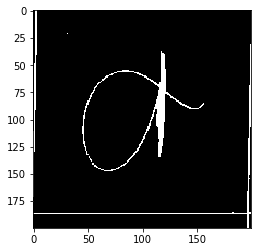

In [26]:
h = []
v = []
plHimage = np.zeros((200,200))
plVimage = np.zeros((200,200))
ExtractHVFeature(N_dataset1[0],0,200,0,200,8,True,h,plHimage)
ExtractHVFeature(N_dataset1[0],0,200,0,200,8,False,v,plVimage)
pt.imshow(N_dataset1[0],cmap='gray')

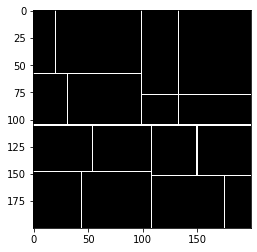

In [27]:
pt.imshow(plHimage,cmap='gray')

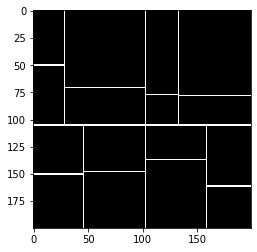

In [28]:
pt.imshow(plVimage,cmap='gray')

#### HOG feature

In [29]:
def HOG(Image): 
    fd, hog_image = hog(Image, orientations=8, pixels_per_cell=(40,40
                                                               ),
                        cells_per_block=(5, 5), visualize=True)
    return fd

### combine feature

In [30]:
# status = 1  // HOG
# status = 2  // Global Feature
# status = 3  // Global and local feature
# status = 4  // local feature
def ExtractFeature(status,N_dataset,resized_dataset):
    FX2 = []
    for si in range(len(N_dataset)):  
        h = []
        l = []
        plHimage = np.zeros((np.shape(N_dataset[si])[0],np.shape(N_dataset[si])[1]))
        plVimage = np.zeros((np.shape(N_dataset[si])[0],np.shape(N_dataset[si])[1]))
        # HOG Feature
        if status == 1:
            hog = list(HOG(N_dataset[si]))
            FX2.append(hog)
        # Global Feature
        if status == 2:
            area = Area(N_dataset[si])
            width = Width(N_dataset[si])
            height = Height(N_dataset[si])
            purewidth = PureWidth(N_dataset[si])
            pureheight = PureHeight(N_dataset[si])
            FX2.append([width]+[height]+[area]+[purewidth]+[pureheight])
        # Global and local feature
        if status == 3:
            area = Area(N_dataset[si])
            width = Width(N_dataset[si])
            height = Height(N_dataset[si])
            purewidth = PureWidth(N_dataset[si])
            pureheight = PureHeight(N_dataset[si])
            ExtractHVFeature(N_dataset[si],0,200,0,200,8,True,h,plHimage)
            ExtractHVFeature(N_dataset[si],0,200,0,200,8,False,l,plVimage)
            FX2.append(h+l+[width]+[height]+[area]+[purewidth]+[pureheight])
        # local feature
        if status == 4:
            ExtractHVFeature(N_dataset[si],0,200,0,200,8,True,h,plHimage)
            ExtractHVFeature(N_dataset[si],0,200,0,200,8,False,l,plVimage)
            FX2.append(h+l)
        # integrated feature
        if status == 5:
            hog = list(HOG(N_dataset[si]))
            area = Area(N_dataset[si])
            width = Width(N_dataset[si])
            height = Height(N_dataset[si])
            purewidth = PureWidth(N_dataset[si])
            pureheight = PureHeight(N_dataset[si])
            ExtractHVFeature(N_dataset[si],0,200,0,200,8,True,h,plHimage)
            ExtractHVFeature(N_dataset[si],0,200,0,200,8,False,l,plVimage)
            FX2.append(hog+[area]+[width]+[height]+[purewidth]+[pureheight]+h+l)
        # HOG+Global
        if status == 6:
            hog = list(HOG(N_dataset[si]))
            area = Area(N_dataset[si])
            width = Width(N_dataset[si])
            height = Height(N_dataset[si])
            purewidth = PureWidth(N_dataset[si])
            pureheight = PureHeight(N_dataset[si])
            FX2.append(hog+[area]+[width]+[height]+[purewidth]+[pureheight])
    scaler = MinMaxScaler()
    FX2=scaler.fit_transform(FX2)
    return FX2 

In [31]:
HOG_F=np.array(ExtractFeature(1,N_dataset1,resized_dataset1))
Global_F=np.array(ExtractFeature(2,N_dataset1,resized_dataset1))
GL_F=np.array(ExtractFeature(3,N_dataset1,resized_dataset1))
Local_F=np.array(ExtractFeature(4,N_dataset1,resized_dataset1))
t_F=np.array(ExtractFeature(5,N_dataset1,resized_dataset1))
HOG_G =np.array(ExtractFeature(6,N_dataset1,resized_dataset1))

<ipython-input-24-33959d1eac05>:12: RuntimeWarning: invalid value encountered in longlong_scalars
  CY=int(np.ceil(htotal/totalactivepixel))
<ipython-input-24-33959d1eac05>:12: RuntimeWarning: invalid value encountered in longlong_scalars
  CY=int(np.ceil(htotal/totalactivepixel))
<ipython-input-24-33959d1eac05>:12: RuntimeWarning: invalid value encountered in longlong_scalars
  CY=int(np.ceil(htotal/totalactivepixel))


In [43]:
print(np.shape(HOG_F))
print(np.shape(Global_F))
print(np.shape(GL_F))
print(np.shape(Local_F))
print(np.shape(t_F))
print(np.shape(HOG_G ))

(625, 200)
(625, 5)
(625, 65)
(625, 60)
(625, 265)
(625, 205)


### Evaluate Nave Bayes,KNN,SVM
#### k =1,2, 5,10,15,20,25

In [32]:
def evaluate(LDAstatus,e,test_size,cls,clsname,X,Y):
    foldacc = []
    X=np.array(X)
    Y=np.array(Y)
    SSS = StratifiedShuffleSplit( test_size=test_size,random_state=10)
    for train_index, test_index in SSS.split(X, Y):
        if LDAstatus ==True:
            lda = LDA(n_components=e)
            x_train =lda.fit_transform(X[train_index], Y[train_index])
            x_test = lda.transform(X[test_index])
            cls.fit(x_train,Y[train_index])
            yhat=cls.predict(x_test)
        else:
            cls.fit(X[train_index],Y[train_index])
            yhat=cls.predict(X[test_index])
        ntruepredict = len(np.where(Y[test_index]==yhat)[0])
        ntotal = len(yhat)
        foldacc.append(ntruepredict/ntotal)
    print('accuracy for '+clsname+' : '+str(np.mean(foldacc))+"+-"+str(np.std(foldacc)))  
    return np.mean(foldacc),np.std(foldacc)
    

In [37]:
def FeaturesClassifiersEvaluate(HOG_F,Global_F,GL_F,Local_F,HOG_G,t_F,L1):
    L1=np.array(L1)
    clsvm=svm.SVC()
    k = [1,2,5,10,15,20,25]
    # features => HOG
    print('features => HOG')
    evaluate(False,1,0.2,clsvm,"SVM",HOG_F,L1)
    clsGNB=GaussianNB()
    evaluate(False,1,0.2,clsGNB,"Bayes",HOG_F,L1)
    for e in k:
        clsKNN = KNeighborsClassifier(n_neighbors=e)
        evaluate(False,1,0.2,clsKNN,"KNN with k = "+str(e),HOG_F,L1)
    
    # features => Global
    print('features => Global')
    clsvm=svm.SVC()
    evaluate(False,1,0.2,clsvm,"SVM",Global_F,L1)
    clsGNB=GaussianNB()
    evaluate(False,1,0.2,clsGNB,"Bayes",Global_F,L1)
    for e in k:
        clsKNN = KNeighborsClassifier(n_neighbors=e)
        evaluate(False,1,0.2,clsKNN,"KNN with k = "+str(e),Global_F,L1)


    # features => Global and local feature
    clsvm=svm.SVC()
    print('features => Global and local feature')
    evaluate(False,1,0.2,clsvm,"SVM",GL_F,L1)
    clsGNB=GaussianNB()
    evaluate(False,1,0.2,clsGNB,"Bayes",GL_F,L1)
    for e in k:
        clsKNN = KNeighborsClassifier(n_neighbors=e)
        evaluate(False,1,0.2,clsKNN,"KNN with k = "+str(e),GL_F,L1)

    # features => local feature
    clsvm=svm.SVC()
    print('features => local feature')
    evaluate(False,1,0.2,clsvm,"SVM",Local_F,L1)
    clsGNB=GaussianNB()
    evaluate(False,1,0.2,clsGNB,"Bayes",Local_F,L1)
    for e in k:
        clsKNN = KNeighborsClassifier(n_neighbors=e)
        evaluate(False,1,0.2,clsKNN,"KNN with k = "+str(e),Local_F,L1)
    # features =>  HOG+ Global features
    clsvm=svm.SVC()
    print('features =>  HOG+Global')
    evaluate(False,1,0.2,clsvm,"SVM",HOG_G,L1)
    clsGNB=GaussianNB()
    evaluate(False,1,0.2,clsGNB,"Bayes",HOG_G,L1)
    for e in k:
        clsKNN = KNeighborsClassifier(n_neighbors=e)
        evaluate(False,1,0.2,clsKNN,"KNN with k = "+str(e),HOG_G,L1)
    print('features =>  Features integrated')
    clsvm=svm.SVC()
    evaluate(False,1,0.2,clsvm,"SVM",t_F,L1)
    clsGNB=GaussianNB()
    evaluate(False,1,0.2,clsGNB,"Bayes",t_F,L1)
    for e in k:
        clsKNN = KNeighborsClassifier(n_neighbors=e)
        evaluate(False,1,0.2,clsKNN,"KNN with k = "+str(e),t_F,L1)

In [38]:
FeaturesClassifiersEvaluate(HOG_F,Global_F,GL_F,Local_F,HOG_G,t_F,L1)

features => HOG
accuracy for SVM : 0.7864+-0.021481154531356083
accuracy for Bayes : 0.23279999999999998+-0.029164361813693092
accuracy for KNN with k = 1 : 0.8343999999999999+-0.03036840463376369
accuracy for KNN with k = 2 : 0.7272+-0.01974234028680492
accuracy for KNN with k = 5 : 0.6799999999999999+-0.01926655132606765
accuracy for KNN with k = 10 : 0.5935999999999999+-0.044079927404658915
accuracy for KNN with k = 15 : 0.5151999999999999+-0.05451752011968262
accuracy for KNN with k = 20 : 0.46799999999999997+-0.04296975680638652
accuracy for KNN with k = 25 : 0.3984+-0.03465025252433234
features => Global
accuracy for SVM : 0.1616+-0.0352
accuracy for Bayes : 0.176+-0.02794279871451677
accuracy for KNN with k = 1 : 0.18639999999999998+-0.018948350851723215
accuracy for KNN with k = 2 : 0.17119999999999996+-0.0336
accuracy for KNN with k = 5 : 0.18319999999999997+-0.019742340286804907
accuracy for KNN with k = 10 : 0.1928+-0.0136
accuracy for KNN with k = 15 : 0.17039999999999997+-

### USE LDA for dimension reduction

In [41]:
component_list = [20,40,60,80,100,124]
k = [1,2,5]
for e in component_list:
    print('HOG + Global features by component number='+str(e))
    clsvm=svm.SVC()
    evaluate(True,e,0.2,clsvm,"SVM",HOG_G,L1)
    for h in k:
        clsKNN = KNeighborsClassifier(n_neighbors=h)
        evaluate(True,e,0.2,clsKNN,"KNN with k = "+str(h),HOG_G,L1)
component_list = [20,40,60,80,100,124]
k = [1,2,5]
for e in component_list:
    print('HOG by component number='+str(e))
    clsvm=svm.SVC()
    evaluate(True,e,0.2,clsvm,"SVM",HOG_F,L1)
    for h in k:
        clsKNN = KNeighborsClassifier(n_neighbors=h)
        evaluate(True,e,0.2,clsKNN,"KNN with k = "+str(h),HOG_F,L1)

HOG + Global features by component number=20
accuracy for SVM : 0.8640000000000001+-0.027712812921102038
accuracy for KNN with k = 1 : 0.8560000000000001+-0.027480902459708276
accuracy for KNN with k = 2 : 0.8311999999999999+-0.029599999999999994
accuracy for KNN with k = 5 : 0.8328000000000001+-0.03877318661136842
HOG + Global features by component number=40
accuracy for SVM : 0.9032000000000002+-0.02160000000000002
accuracy for KNN with k = 1 : 0.8872+-0.024903011866037404
accuracy for KNN with k = 2 : 0.8624+-0.028352072234670987
accuracy for KNN with k = 5 : 0.8615999999999999+-0.030578423765786254
HOG + Global features by component number=60
accuracy for SVM : 0.9104000000000001+-0.02257077756746541
accuracy for KNN with k = 1 : 0.8991999999999999+-0.025348767228407773
accuracy for KNN with k = 2 : 0.8704000000000001+-0.0307349963396777
accuracy for KNN with k = 5 : 0.8615999999999999+-0.02702295320648728
HOG + Global features by component number=80
accuracy for SVM : 0.9104000000

### Varies distribution of test train
#### # test =2 sign / #train = 3 sign
#### # test =3 sign / #train = 2 sign


In [42]:
test_size = [0.2,0.4,0.6]
K = [1,2,5]
for e in test_size:
    print('HOG+Global features by component number=60 ,test_size = '+str(e))
    clsvm=svm.SVC()
    evaluate(True,60,e,clsvm,"SVM",HOG_G,L1)
    for k in K:
        clsKNN = KNeighborsClassifier(n_neighbors=k)
        evaluate(True,60,e,clsKNN,"KNN with k = "+str(k),HOG_G,L1)

HOG+Global features by component number=60 ,test_size = 0.2
accuracy for SVM : 0.9104000000000001+-0.02257077756746541
accuracy for KNN with k = 1 : 0.8991999999999999+-0.025348767228407773
accuracy for KNN with k = 2 : 0.8704000000000001+-0.0307349963396777
accuracy for KNN with k = 5 : 0.8615999999999999+-0.02702295320648728
HOG+Global features by component number=60 ,test_size = 0.4
accuracy for SVM : 0.8436+-0.025200000000000007
accuracy for KNN with k = 1 : 0.8443999999999999+-0.026740231861373236
accuracy for KNN with k = 2 : 0.8099999999999999+-0.02072679425285056
accuracy for KNN with k = 5 : 0.8039999999999999+-0.018066543665017917
HOG+Global features by component number=60 ,test_size = 0.6
accuracy for SVM : 0.5730666666666665+-0.026996625303503736
accuracy for KNN with k = 1 : 0.5773333333333333+-0.028025385317997354
accuracy for KNN with k = 2 : 0.5698666666666667+-0.02391243284244506
accuracy for KNN with k = 5 : 0.3794666666666666+-0.023126319782158736
